loss dictionar:
- 'loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'

#### unlike others:
- `loss_dict = model(input, labels)`
here unlike classification, models takes both (X,Y). It has loss function implemented under the hood.

Classes = number of classes + 1(background)
`bboxes` shape must be [N,4]

For Crossentropy loss that is inside the model, It needs either `0D` or `1D` tensor. Not Multidimension Tensor.

#### In TEST/PREDICT mode:
- `output = model(inputs)
- output is a dict with `boxes`, `labels`, `scores`.


In [ ]:
a= []
while(1):
  a.append("1")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd
import os
import copy
import math
from PIL import Image
import cv2

from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torchvision.datasets as dset
from torchvision.utils import draw_bounding_boxes

In [ ]:
from pycocotools.coco import COCO
import albumentations as A  
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(100, 100), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(200, 200), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
def check_boxes(boxes):
  new_boxes= []
  for box in boxes:
    new_box = []
    for val in box:
      new_box.append(abs(val))
    new_boxes.append(new_box)
  return new_boxes

In [ ]:
class Antsandbees(datasets.VisionDataset):
    def __init__(self, root, json_path, transforms=None):
        super().__init__(Antsandbees)
        
        self.root = root
        self.transforms = transforms
        self.coco = COCO(json_path) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
        #print(self.ids,"iddddddddddddddd")
         
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target]
        boxes = check_boxes(boxes)
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        # print("New boxes :", new_boxes)
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        targ = {} 
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id']+1 for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ
   
    def __len__(self):
        return len(self.ids)    

In [ ]:
dataset_path = '/content/drive/MyDrive/coolab/train'
Json_file = "/content/drive/MyDrive/coolab/3.json_annotation/output.json"
transforms = get_transforms()

Json_path = os.path.join(dataset_path, Json_file)

In [ ]:
Json_path

'/content/drive/MyDrive/coolab/3.json_annotation/output.json'

In [ ]:
train_dataset = Antsandbees(dataset_path, Json_path, transforms= transforms)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [ ]:
train_dataset


Dataset Antsandbees
    Number of datapoints: 244
    Root location: /content/drive/MyDrive/coolab/train
    Compose([
  Resize(always_apply=False, p=1, height=200, width=200, interpolation=1),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 3

model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Modifying the model to add a different backbone

In [ ]:
# backbone =  torchvision.models.mobilenet_v2().features
# backbone.out_channels = 1280


# anchor_generator = AnchorGenerator(sizes=((32,64,128,256,512),),aspect_ratios=((0.5,1.0,2.0),))
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)


# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
train_dataset

Dataset Antsandbees
    Number of datapoints: 244
    Root location: /content/drive/MyDrive/coolab/train
    Compose([
  Resize(always_apply=False, p=1, height=200, width=200, interpolation=1),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})

In [ ]:
dl_train = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
epochs = 5
lr = 0.0001
optimizer = torch.optim.SGD(model.parameters() , lr, momentum = 0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

losses = []
for epoch in range(epochs):
  running_loss = 0
  total_train = 0
  correct_train = 0
    print("Epoch :", epoch)
    for i,data in enumerate(dl_train):
        inputs,label = data                          
        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        label = [{k:v[0].to(device) for k,v in label.items()}]
        
        loss_dict = model(inputs,label)
        losses = sum([loss for loss in loss_dict.values()])

        losses.backward()
        print("losses :", losses)
        optimizer.step()

        

Epoch : 0
losses : tensor(1.6610, grad_fn=<AddBackward0>)
losses : tensor(1.4886, grad_fn=<AddBackward0>)
losses : tensor(1.6948, grad_fn=<AddBackward0>)
losses : tensor(1.4089, grad_fn=<AddBackward0>)
losses : tensor(1.3659, grad_fn=<AddBackward0>)
losses : tensor(1.1514, grad_fn=<AddBackward0>)
losses : tensor(1.1295, grad_fn=<AddBackward0>)
losses : tensor(1.0473, grad_fn=<AddBackward0>)
losses : tensor(0.8797, grad_fn=<AddBackward0>)
losses : tensor(1.2441, grad_fn=<AddBackward0>)
losses : tensor(0.5974, grad_fn=<AddBackward0>)
losses : tensor(0.6245, grad_fn=<AddBackward0>)
losses : tensor(0.8508, grad_fn=<AddBackward0>)
losses : tensor(0.9445, grad_fn=<AddBackward0>)
losses : tensor(0.5363, grad_fn=<AddBackward0>)
losses : tensor(0.3758, grad_fn=<AddBackward0>)
losses : tensor(0.5223, grad_fn=<AddBackward0>)
losses : tensor(0.4581, grad_fn=<AddBackward0>)
losses : tensor(0.7068, grad_fn=<AddBackward0>)
losses : tensor(0.2317, grad_fn=<AddBackward0>)
losses : tensor(0.3186, grad_f

In [ ]:
dl_test= dl_train
losses = []
model = model.eval()

with torch.no_grad():
  for i,data in enumerate(dl_test):
      inputs,label = data                       
      inputs = inputs.to(device)
      label = [{k:v[0].to(device) for k,v in label.items()}]
      
      output = model(inputs)
      accuary_val, iou_val = metric()
      break

In [ ]:
output

[{'boxes': tensor([[ 11.7115,  23.6975,  87.1319,  70.5968],
          [  9.5655,  18.8935,  51.0020,  75.1996],
          [  2.7356,  11.6066,  82.6599,  57.1801],
          [ 20.8225,   8.4175,  66.6616,  76.4417],
          [ 28.9221,  27.8988,  72.3456,  67.6424],
          [ 25.4577,   0.6799,  92.0700,  63.8015],
          [ 14.3504,  27.5852,  61.6517,  58.8349],
          [ 16.8872,  22.4322,  32.0182,  60.4520],
          [ 24.8432,  30.9235,  49.9105,  74.4361],
          [ 32.2871,  21.1770,  82.1648,  50.4669],
          [ 14.9003,  27.8324,  42.2019,  67.9251],
          [ 37.7054,  16.8921,  89.4469,  83.4159],
          [ 51.9098,  21.6308,  85.1071,  63.9926],
          [ 20.5812,  16.9778,  45.3112,  60.7066],
          [  1.3894,  26.2113,  46.2105,  54.3776],
          [ 33.2779,  25.5802,  59.1673,  81.4735],
          [  7.2943,  38.4903,  60.4895,  66.8225],
          [  0.1126,  28.7117,  55.5492,  97.7814],
          [ 26.6380,  28.2772,  78.2541,  95.4833],
   

In [ ]:
output[0]['boxes'][output[0]['scores'] > 0.50]

tensor([[11.7115, 23.6975, 87.1319, 70.5968]], device='cuda:0')

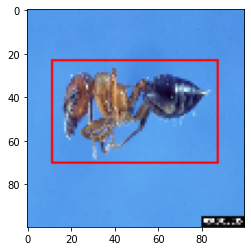

In [ ]:
import matplotlib.pyplot as plt

out = torchvision.transforms.ToPILImage()(inputs.squeeze(0))
bbox = [11.7115, 23.6975, 87.1319, 70.5968]
from PIL import ImageDraw

im = ImageDraw.Draw(out)
im.rectangle(bbox, fill=None, outline='red', width=1)
plt.imshow(out)
plt.show()

torch.Size([3, 100, 100])